#  Learn Modulation and Demodulation in the AWGN Channel with Deep Neural Networks by Autoencoders and End-to-end Training

#  QAM Demodulation in Nonlinear Channels with Deep Neural Networks

This code is provided as supplementary material of the invited presentation at ECOC 2020 by Laurent Schmalen

> Boris Karanov, Polina Bayvel, and Laurent Schmalen, "End-to-end Learning in Optical Fiber Communications: Concept and Transceiver Design," Proc. European Conference on Optical Communications (ECOC), Brussels, Belgium, Dec. 2020

_Acknowledgment_: Parts of this code have been developed by Benedikt Geiger, whose help is greatly appreciated

This code illustrates
* End-to-end-learning of modulation scheme and demodulator in an AWGN channel with time-varying batch size

### Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


### Helper function to compute Symbol Error Rate (SER)

In [3]:
# helper function to compute the symbol error rate
def SER(predictions, labels):
    return (np.sum(np.argmax(predictions, 1) != labels) / predictions.shape[0])

### Define Parameters

Here, we consider the simple AWGN channel.

In [4]:
# number of symbols (here 16 for a 16-QAM equivalent)
M = 16

EbN0 = 11

# noise standard deviation for each dimension
sigma_n = np.sqrt((1/2/np.log2(M)) * 10**(-EbN0/10))

Here, we define the parameters of the neural network and training, generate the validation set and a helping set to show the decision regions

In [5]:
# validation set. Training examples are generated on the fly
N_valid = 100000

# Transmitter is just a lookup and doesn't need an artificial neural network in this case

# number of neurons in hidden layers at receiver
hidden_neurons_RX_1 = 50
hidden_neurons_RX_2 = 50
hidden_neurons_RX_3 = 50
hidden_neurons_RX_4 = 50
hidden_neurons_RX = [hidden_neurons_RX_1, hidden_neurons_RX_2, hidden_neurons_RX_3, hidden_neurons_RX_4]

# Generate Validation Data
y_valid = np.random.randint(M,size=N_valid)
y_valid_onehot = np.eye(M)[y_valid]

# meshgrid for plotting
ext_max = 1.8  # assume we normalize the constellation to unit energy than 1.5 should be sufficient in most cases (hopefully)
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,400), np.linspace(-ext_max,ext_max,400))
meshgrid = np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1)))) 

### Define the architecture of the autoencoder, i.e. the neural network

This is the main neural network/Autoencoder with transmitter, channel and receiver. Transmitter and receiver each with ELU activation function. Note that the final layer does *not* use a `softmax` function, as this function is already included in the `CrossEntropyLoss`.

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, hidden_neurons_RX):
        super(Autoencoder, self).__init__()
        # Define Transmitter Layer: Linear function, M input neurons (symbols), 2 output neurons (real and imaginary part)        
        self.fcT = nn.Linear(M,2) 
        
        # Define Receiver Layer: Linear function, 2 input neurons (real and imaginary part), M output neurons (symbols)
        self.fcR1 = nn.Linear(2,hidden_neurons_RX[0]) 
        self.fcR2 = nn.Linear(hidden_neurons_RX[0], hidden_neurons_RX[1]) 
        self.fcR3 = nn.Linear(hidden_neurons_RX[1], hidden_neurons_RX[2]) 
        self.fcR4 = nn.Linear(hidden_neurons_RX[2], hidden_neurons_RX[3]) 
        self.fcR5 = nn.Linear(hidden_neurons_RX[3], M) 

        # Non-linearity (used in receiver)
        self.activation_function = nn.ELU()      

    def forward(self, x):
        # compute output
        encoded = self.network_transmitter(x)
        # compute normalization factor and normalize channel output
        norm_factor = torch.sqrt(torch.mean(torch.mul(encoded,encoded)) * 2 )                            
        modulated = encoded / norm_factor    
        received = self.channel_model(modulated)
        logits = self.network_receiver(received)
        return logits
        
    def network_transmitter(self,batch_labels):
        out = self.fcT(batch_labels)
        return out
    
    def network_receiver(self,inp):
        out = self.activation_function(self.fcR1(inp))
        out = self.activation_function(self.fcR2(out))
        out = self.activation_function(self.fcR3(out))
        out = self.activation_function(self.fcR4(out))
        logits = self.activation_function(self.fcR5(out))
        return logits
    
    def channel_model(self,modulated):
        # just add noise, nothing else
        received = torch.add(modulated, sigma_n*torch.randn(len(modulated),2).to(device))
        return received

### Train the NN and evaluate it at the end of each epoch

Here the idea is to vary the batch size during training. In the first iterations, we start with a small batch size to rapidly get to a working solution. The closer we come towards the end of the training we increase the batch size. If keeping the abtch size small, it may happen that there are no misclassifications in a small batch and there is no incentive of the training to improve. A larger batch size will most likely contain errors in the batch and hence there will be incentive to keep on training and improving. 

Here, the data is generated on the fly inside the graph, by using PyTorch random number generation. As PyTorch does not natively support complex numbers (at least in early versions), we decided to replace the complex number operations in the channel by a simple rotation matrix and treating real and imaginary parts separately.

We use the ELU activation function inside the neural network and employ the Adam optimization algorithm.

Now, carry out the training as such. First initialize the variables and then loop through the training. Here, the epochs are not defined in the classical way, as we do not have a training set per se. We generate new data on the fly and never reuse data. We change the batch size in each epoch.<br>

To get the constellation symbols and the received data, we apply the model after each epoch.

In [7]:
model = Autoencoder(hidden_neurons_RX)
model.to(device)

softmax = nn.Softmax(dim=1)

# Cross Entropy loss
loss_fn = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters())  


# Training parameters
num_epochs = 500
batches_per_epoch = 10

# Vary batch size during training
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs)

validation_SERs = np.zeros(num_epochs)
validation_received = []
decision_region_evolution = []
constellations = []

print('Start Training')
for epoch in range(num_epochs):
    
    batch_labels = torch.empty(int(batch_size_per_epoch[epoch]), device=device)

    for step in range(batches_per_epoch):
        # Generate training data: In most cases, you have a dataset and do not generate a training dataset during training loop
        # sample new mini-batch directory on the GPU (if available)        
        batch_labels.random_(M)
        batch_labels_onehot = torch.zeros(int(batch_size_per_epoch[epoch]), M, device=device)
        batch_labels_onehot[range(batch_labels_onehot.shape[0]), batch_labels.long()]=1

        # Propagate (training) data through the net
        logits = model(batch_labels_onehot)

        # compute loss
        loss = loss_fn(logits.squeeze(), batch_labels.long())

        # compute gradients
        loss.backward()
        
        # Adapt weights
        optimizer.step()
        
        # reset gradients
        optimizer.zero_grad()
        
    # compute validation SER
    out_valid = softmax(model(torch.Tensor(y_valid_onehot).to(device)))
    validation_SERs[epoch] = SER(out_valid.detach().cpu().numpy().squeeze(), y_valid)
    print('Validation SER after epoch %d: %f (loss %1.8f)' % (epoch, validation_SERs[epoch], loss.detach().cpu().numpy()))                
    
    # calculate and store received validation data
    encoded = model.network_transmitter(torch.Tensor(y_valid_onehot).to(device))
    norm_factor = torch.sqrt(torch.mean(torch.mul(encoded,encoded)) * 2 )                            
    modulated = encoded / norm_factor    
    received = model.channel_model(modulated)
    validation_received.append(received.detach().cpu().numpy())
    
    # calculate and store constellation
    encoded = model.network_transmitter(torch.eye(M).to(device))
    norm_factor = torch.sqrt(torch.mean(torch.mul(encoded,encoded)) * 2 )                            
    modulated = encoded / norm_factor 
    constellations.append(modulated.detach().cpu().numpy())
        
    # store decision region for generating the animation
    mesh_prediction = softmax(model.network_receiver(torch.Tensor(meshgrid).to(device)))
    decision_region_evolution.append(0.195*mesh_prediction.detach().cpu().numpy() + 0.4)
    
print('Training finished')

Start Training
Validation SER after epoch 0: 0.872950 (loss 2.67663646)
Validation SER after epoch 1: 0.868210 (loss 2.50495481)
Validation SER after epoch 2: 0.875450 (loss 2.20746088)
Validation SER after epoch 3: 0.863880 (loss 2.14270115)
Validation SER after epoch 4: 0.732970 (loss 1.97395468)
Validation SER after epoch 5: 0.585740 (loss 1.70455658)
Validation SER after epoch 6: 0.472100 (loss 1.40856421)
Validation SER after epoch 7: 0.399230 (loss 1.11905682)
Validation SER after epoch 8: 0.253230 (loss 0.90214294)
Validation SER after epoch 9: 0.218400 (loss 0.66961014)
Validation SER after epoch 10: 0.180080 (loss 0.52577269)
Validation SER after epoch 11: 0.044800 (loss 0.43011200)
Validation SER after epoch 12: 0.022560 (loss 0.22944869)
Validation SER after epoch 13: 0.018110 (loss 0.12674454)
Validation SER after epoch 14: 0.011810 (loss 0.09251163)
Validation SER after epoch 15: 0.009520 (loss 0.08080762)
Validation SER after epoch 16: 0.007910 (loss 0.04519530)
Validatio

Validation SER after epoch 141: 0.001950 (loss 0.00264797)
Validation SER after epoch 142: 0.001610 (loss 0.00603446)
Validation SER after epoch 143: 0.001600 (loss 0.00513276)
Validation SER after epoch 144: 0.001690 (loss 0.00701436)
Validation SER after epoch 145: 0.001730 (loss 0.00646056)
Validation SER after epoch 146: 0.001650 (loss 0.00553586)
Validation SER after epoch 147: 0.001850 (loss 0.00217786)
Validation SER after epoch 148: 0.001770 (loss 0.01033535)
Validation SER after epoch 149: 0.002160 (loss 0.00680196)
Validation SER after epoch 150: 0.001920 (loss 0.00408178)
Validation SER after epoch 151: 0.002180 (loss 0.00736478)
Validation SER after epoch 152: 0.001900 (loss 0.00444407)
Validation SER after epoch 153: 0.002020 (loss 0.00516869)
Validation SER after epoch 154: 0.001470 (loss 0.01251253)
Validation SER after epoch 155: 0.001860 (loss 0.00548534)
Validation SER after epoch 156: 0.001500 (loss 0.00528304)
Validation SER after epoch 157: 0.001930 (loss 0.0058823

Validation SER after epoch 280: 0.001560 (loss 0.00407593)
Validation SER after epoch 281: 0.001700 (loss 0.00491883)
Validation SER after epoch 282: 0.001610 (loss 0.00446819)
Validation SER after epoch 283: 0.001910 (loss 0.00421005)
Validation SER after epoch 284: 0.001490 (loss 0.00629600)
Validation SER after epoch 285: 0.001880 (loss 0.00344162)
Validation SER after epoch 286: 0.002010 (loss 0.00396708)
Validation SER after epoch 287: 0.001750 (loss 0.00629146)
Validation SER after epoch 288: 0.001690 (loss 0.00796483)
Validation SER after epoch 289: 0.001460 (loss 0.00569327)
Validation SER after epoch 290: 0.001500 (loss 0.00622749)
Validation SER after epoch 291: 0.001660 (loss 0.00559369)
Validation SER after epoch 292: 0.001650 (loss 0.00641340)
Validation SER after epoch 293: 0.001480 (loss 0.00643442)
Validation SER after epoch 294: 0.001500 (loss 0.00212411)
Validation SER after epoch 295: 0.001940 (loss 0.00440665)
Validation SER after epoch 296: 0.001630 (loss 0.0052987

Validation SER after epoch 419: 0.001430 (loss 0.00522910)
Validation SER after epoch 420: 0.001560 (loss 0.00415623)
Validation SER after epoch 421: 0.001770 (loss 0.00435137)
Validation SER after epoch 422: 0.001690 (loss 0.00595862)
Validation SER after epoch 423: 0.001540 (loss 0.00361367)
Validation SER after epoch 424: 0.001450 (loss 0.00722848)
Validation SER after epoch 425: 0.001510 (loss 0.00372215)
Validation SER after epoch 426: 0.001440 (loss 0.00204151)
Validation SER after epoch 427: 0.001480 (loss 0.00427256)
Validation SER after epoch 428: 0.001500 (loss 0.00322263)
Validation SER after epoch 429: 0.001800 (loss 0.00606549)
Validation SER after epoch 430: 0.001480 (loss 0.00589756)
Validation SER after epoch 431: 0.001650 (loss 0.00325471)
Validation SER after epoch 432: 0.001280 (loss 0.00594941)
Validation SER after epoch 433: 0.001240 (loss 0.00410308)
Validation SER after epoch 434: 0.001670 (loss 0.00523768)
Validation SER after epoch 435: 0.001830 (loss 0.0038908

### Evaluate results (I)

Plt decision region and scatter plot of the validation set. Note that the validation set is **only** used for computing SERs and plotting, there is no feedback towards the training!

Minimum SER obtained: 0.00124 (epoch 433 out of 500)
The corresponding constellation symbols are:
 [[-0.20618084  1.1686395 ]
 [-0.15361436  0.46696123]
 [-0.09990895 -0.21713883]
 [-1.2429442  -0.34635362]
 [-1.2891873   0.34335887]
 [-0.7395734   0.75429636]
 [ 0.38529333  0.88958216]
 [ 0.5655199  -1.1560118 ]
 [-0.64060897 -0.63412404]
 [ 0.4969633  -0.4608247 ]
 [ 1.072776   -0.05168209]
 [ 0.44662452  0.19377702]
 [ 1.1267428  -0.71228725]
 [-0.67298186  0.05681901]
 [ 1.0015169   0.64960736]
 [-0.05202831 -0.9017595 ]]


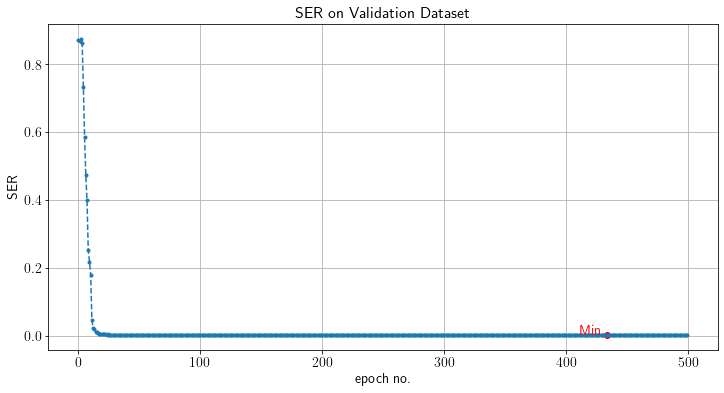

In [8]:
cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

# find minimum SER from validation set
min_SER_iter = np.argmin(validation_SERs)
ext_max_plot = 1.05*max(max(abs(validation_received[min_SER_iter][:,0])), max(abs(validation_received[min_SER_iter][:,1])))

plt.figure(figsize=(12,6))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))
    
plt.plot(validation_SERs,marker='.',linestyle='--')
plt.scatter(min_SER_iter,validation_SERs[min_SER_iter],marker='o',c='red')
plt.annotate('Min', (0.95*min_SER_iter,1.4*validation_SERs[min_SER_iter]),c='red')
plt.xlabel('epoch no.',fontsize=14)
plt.ylabel('SER',fontsize=14)
plt.grid(which='both')
plt.title('SER on Validation Dataset',fontsize=16)

print('Minimum SER obtained: %1.5f (epoch %d out of %d)' % (validation_SERs[min_SER_iter], min_SER_iter, len(validation_SERs)))
print('The corresponding constellation symbols are:\n', constellations[min_SER_iter])

### Evaluate results (II)

Text(0.5, 1.0, 'Decision regions')

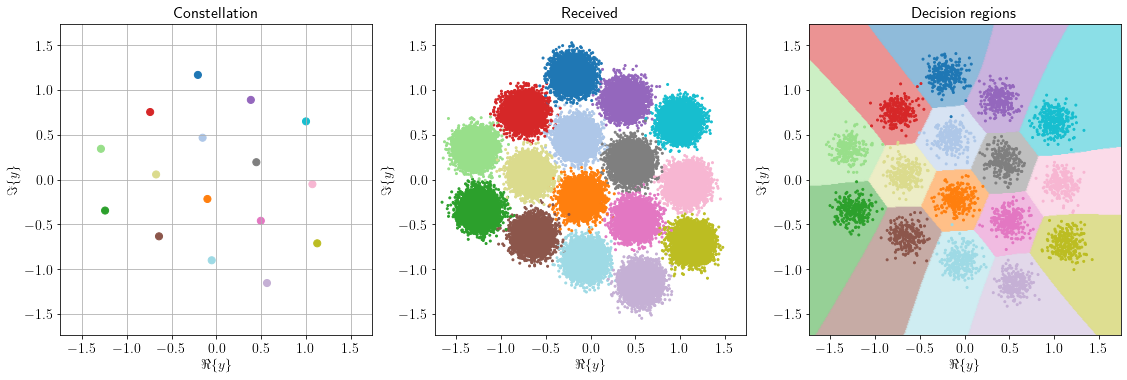

In [9]:
%matplotlib inline
plt.figure(figsize=(19,6))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=True)
    
plt.subplot(131)
plt.scatter(constellations[min_SER_iter][:,0], constellations[min_SER_iter][:,1], c=range(M), cmap='tab20',s=50)
plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=14)
plt.ylabel(r'$\Im\{y\}$',fontsize=14)
plt.xlim((-ext_max_plot,ext_max_plot))
plt.ylim((-ext_max_plot,ext_max_plot))
plt.grid(which='both')
plt.title('Constellation',fontsize=16)

plt.subplot(132)
#plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
plt.scatter(validation_received[min_SER_iter][:,0], validation_received[min_SER_iter][:,1], c=y_valid, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=14)
plt.ylabel(r'$\Im\{y\}$',fontsize=14)
plt.xlim((-ext_max_plot,ext_max_plot))
plt.ylim((-ext_max_plot,ext_max_plot))
plt.title('Received',fontsize=16)

plt.subplot(133)
decision_scatter = np.argmax(decision_region_evolution[min_SER_iter], 1)
plt.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
plt.scatter(validation_received[min_SER_iter][0:4000,0], validation_received[min_SER_iter][0:4000,1], c=y_valid[0:4000], cmap='tab20',s=4)
plt.axis('scaled')
plt.xlim((-ext_max_plot,ext_max_plot))
plt.ylim((-ext_max_plot,ext_max_plot))
plt.xlabel(r'$\Re\{y\}$',fontsize=14)
plt.ylabel(r'$\Im\{y\}$',fontsize=14)
plt.title('Decision regions',fontsize=16)

#plt.savefig('decision_region_AWGN_AE_EbN0%1.1f_M%d.pdf' % (EbN0,M), bbox_inches='tight')

### Generate animation and save as a gif. (Evaluate results III)

<IPython.core.display.Javascript object>


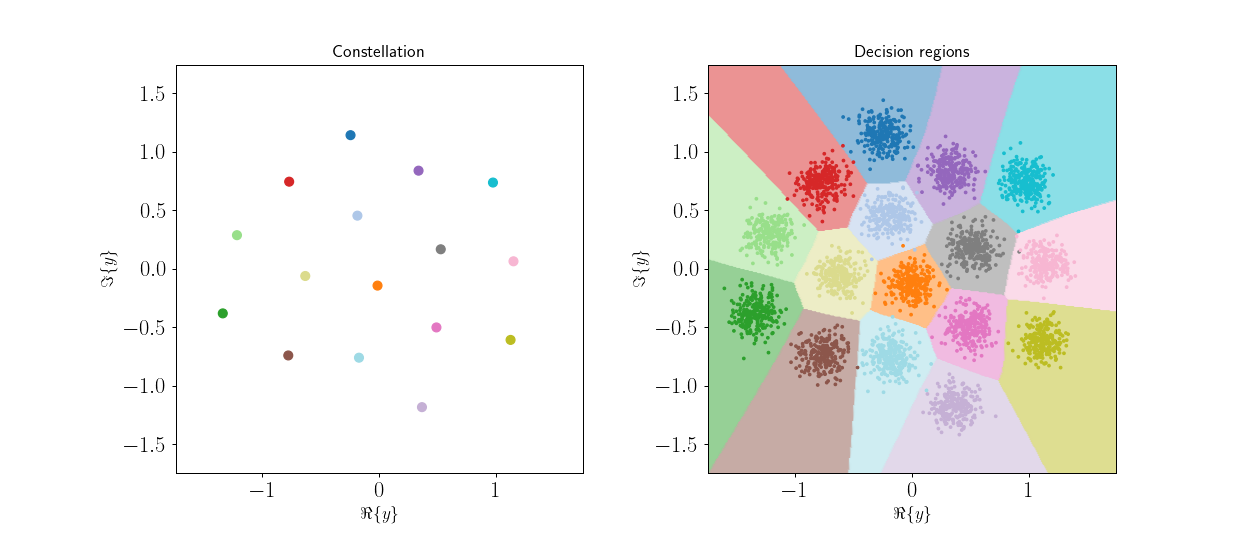

In [10]:
%matplotlib notebook
%matplotlib notebook
# Generate animation
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.

font = {'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.axis('scaled')
ax2.axis('scaled')

written = False
def animate(i):
    ax1.clear()
    ax1.scatter(constellations[i][:,0], constellations[i][:,1], c=range(M), cmap='tab20',s=50)

    ax2.clear()
    decision_scatter = np.argmax(decision_region_evolution[i], 1)
    ax2.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
    ax2.scatter(validation_received[i][0:4000,0], validation_received[i][0:4000,1], c=y_valid[0:4000], cmap='tab20',s=4)
    
    ax1.set_xlim(( -ext_max_plot, ext_max_plot))
    ax1.set_ylim(( -ext_max_plot, ext_max_plot))
    ax2.set_xlim(( -ext_max_plot, ext_max_plot))
    ax2.set_ylim(( -ext_max_plot, ext_max_plot))
    ax1.set_title('Constellation', fontsize=14)
    ax2.set_title('Decision regions', fontsize=14)
    
    ax1.set_xlabel(r'$\Re\{y\}$',fontsize=14)
    ax1.set_ylabel(r'$\Im\{y\}$',fontsize=14)
    ax2.set_xlabel(r'$\Re\{y\}$',fontsize=14)
    ax2.set_ylabel(r'$\Im\{y\}$',fontsize=14)

# limit animation to 100 frames    
anim = animation.FuncAnimation(fig, animate, frames=min(min_SER_iter+1,100), interval=200, blit=False)
fig.show()

In [11]:
anim.save('learning_AWGN_AE_EbN0%1.1f_M%d.gif' % (EbN0,M), writer=PillowWriter(fps=5))